## Analysing H1B Visa data Trends

H1B visa is a nonimmigrant visa issued to gradaute level applicants allowing them to work in the United States. The employer sponsors the H1B visa for workers with theoretical or technical expertise in specialized fields such as in IT, finance, accounting etc. An interesting fact about immigrant workers is that about 52 percent of new Silicon valley companies were founded by such workers during 1995 and 2005. Some famous CEOs like Indira Nooyi (Pepsico), Elon Musk (Tesla), Sundar Pichai (Google),Satya Nadella (Microsoft) once arrived to the US on a H1B visa.\
**Motivation**: Our team consists of five international graduate students, in the future we will be applying for H1B visa. The visa application process seems very long, complicated and uncertain. So we decided to understand this process and use Machine learning algorithms to predict the acceptance rate and trends of H1B visa.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install autocorrect
import string,nltk,warnings,sklearn
import pandas as pd
import numpy as np
import read_files as rd
import visualizations as vz
import plotly.graph_objects as go
import plotly.tools as tls
import cleaning as cw
import baseline as blc
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from autocorrect import Speller 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder #ONE HOT ENCODING
from sklearn.ensemble import RandomForestClassifier #Build model - Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import gensim.downloader as api
from sklearn.metrics import precision_recall_curve
nltk.download('wordnet')
nltk.download('words')
from sklearn.tree import DecisionTreeClassifier

### Data 
The data used in the project has been collected from <a href="https://www.foreignlaborcert.doleta.gov/performancedata.cfm">the Office of Foreign Labor Certification (OFLC).</a>The Data provides insight into each petition with information such as the Job title, Wage, Employer, Worksite location etc. To get the dataset click on the above link-> click on Disclosure data -> scroll down to H1B data.\


In [0]:
link2015='/content/gdrive/My Drive/H1B_project/H-1B_Disclosure_Data_FY15_Q4.csv'
link2016='/content/gdrive/My Drive/H1B_project/H-1B_Disclosure_Data_FY16.csv'
link2017='/content/gdrive/My Drive/H1B_project/H-1B_Disclosure_Data_FY17.csv'
link2018='/content/gdrive/My Drive/H1B_project/H-1B_Disclosure_Data_FY2018_EOY.csv'
link2019='/content/gdrive/My Drive/H1B_project/H-1B_Disclosure_Data_FY2019.csv'
#read csv fuction to read and concatenate all the datasets
cleaned=rd.read_csv(pd,link2015,link2016,link2017,link2018,link2019)

In [4]:
original=cleaned.copy()
cleaned.shape

(3594214, 15)

### Exploratory Data Analysis
Before we begin working on our data we need to understand the traits of our data which we accomplish using EDA. We see that we have about 260 columns , not all 260 columns have essential information that contributes to our analysis. Hence we pick out the columns such as case status( Accepted/ Denied) ,Employer, Job title etc.We can look at all the colums and the types of object in each column using cleaned.info(). We also use cleaned['column_name'].value_counts() to find the classes in the column along with the count. For feature engineering we are converting quantitative data to categorical.
The steps for data cleaning start from EDA till the baseline classifier, follow the comments to understand the cleaning steps. 


####Granularity:
Each row in the dataframe represents an Electronically filles application that was filled by the employer sponsoring the H1b Visa and the application is processed by OFLC and data columns such as DECISION_DATE, CASE_STATUS are added. We can see the dataframe for this H1B data below. 

In [5]:
cleaned.dropna(inplace=True)# Drop all null values from the dataframe
cleaned.head(3)

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,FULL_TIME_POSITION,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,H1B_DEPENDENT
0,I-200-09121-701936,WITHDRAWN,2/5/2015,2/5/2015,H-1B,Y,MECHANICAL ENGINEER,17-2141.00,MECHANICAL ENGINEERS,"MEDTRONIC, INC.",20000,Year,EDEN PRAIRIE,CA,N
1,I-200-09146-796321,CERTIFIED,12/12/2014,12/18/2014,H-1B,Y,ASSISTANT PROFESSOR,25-1032,"ENGINEERING TEACHERS, POSTSECONDARY",UNIVERSITY OF OKLAHOMA,85000.00,Year,NORMAN,OK,N
2,I-200-09180-329758,WITHDRAWN,1/3/2013,12/15/2014,H-1B,Y,RELEASE AND SOFTWARE TEST MANAGER,15-1799,"COMPUTER OCCUPATIONS, ALL OTHER*",NOKIA INC.,94000,Year,SAN DIEGO,CA,N


In [6]:
cleaned['VISA_CLASS'].value_counts()

H-1B               2504369
E-3 Australian        1761
H-1B1 Chile            300
H-1B1 Singapore        284
Name: VISA_CLASS, dtype: int64

In [0]:
# the dataset has categories for Visa which are not of use , we require only H1B visa type , hence we drop all records with other visa types
cleaned.drop(labels=cleaned.loc[cleaned['VISA_CLASS']!='H-1B'].index , inplace=True)
cleaned['CASE_STATUS'].value_counts() # similarly we have 4 classes of case status which we do not require

In [0]:
#In case status column we can drop withdrawn records and certified-withdrawn records
cleaned.drop(labels=cleaned.loc[cleaned['CASE_STATUS']=='WITHDRAWN'].index , inplace=True)
cleaned.drop(labels=cleaned.loc[cleaned['CASE_STATUS']=='CERTIFIED-WITHDRAWN'].index , inplace=True)

In [52]:
cleaned.info() #Gives data about the columns in the dataframe and the object type pf each dataframe, we get the same number of non-null count for all columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648780 entries, 143 to 664612
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   CASE_NUMBER            1648780 non-null  object
 1   CASE_STATUS            1648780 non-null  object
 2   CASE_SUBMITTED         1648780 non-null  object
 3   DECISION_DATE          1648780 non-null  object
 4   VISA_CLASS             1648780 non-null  object
 5   FULL_TIME_POSITION     1648780 non-null  object
 6   JOB_TITLE              1648780 non-null  object
 7   SOC_CODE               1648780 non-null  object
 8   SOC_TITLE              1648780 non-null  object
 9   EMPLOYER_NAME          1648780 non-null  object
 10  WAGE_RATE_OF_PAY_FROM  1648780 non-null  object
 11  WAGE_UNIT_OF_PAY       1648780 non-null  object
 12  WORKSITE_CITY          1648780 non-null  object
 13  WORKSITE_STATE         1648780 non-null  object
 14  H1B_DEPENDENT          1648780 no

####Temporality
The data is available from 1/1/2015 to  9/9/2019

In [10]:
max_date=cleaned.CASE_SUBMITTED.max()	
min_date=cleaned.CASE_SUBMITTED.min()
print("The date in the dataset ranges from "+str(max_date)+" to",min_date)

The date in the dataset ranges from 9/9/2019 9:59 to 1/1/2015


In [0]:
#the column wages has a mix of both string and float value types and some record have the symbol '$' which we want to remove
cleaned['WAGES']=cleaned['WAGE_RATE_OF_PAY_FROM'].apply(cw.clean_wages).astype('float')
# the wage information that we have available has different unit of pay
cleaned['WAGE_UNIT_OF_PAY'].value_counts()

In [0]:
cleaned= cw.clean_wageUnit(np,cleaned)# we convert the different units of pay to the type 'Year'
cleaned.drop(columns=['WAGE_RATE_OF_PAY_FROM','WAGE_UNIT_OF_PAY'],axis=1,inplace=True)

In [0]:
print(cleaned['WAGES'].describe())#checking if the WAGES column have outliers
sns.boxplot(y=cleaned['WAGES'])
plt.show()

We can see that we have large outliers , we can remove them from the data. 

In [0]:
# Remove the outliers.
lowerBound = 0.001
upperBound = 0.95
result = cleaned.WAGES.quantile([lowerBound, upperBound])
cleaned = cleaned[(result.loc[lowerBound] < cleaned.WAGES.values) &\
                  (cleaned.WAGES.values < result.loc[upperBound])]

print(cleaned['WAGES'].describe())
sns.boxplot(y=cleaned['WAGES'])
plt.show()

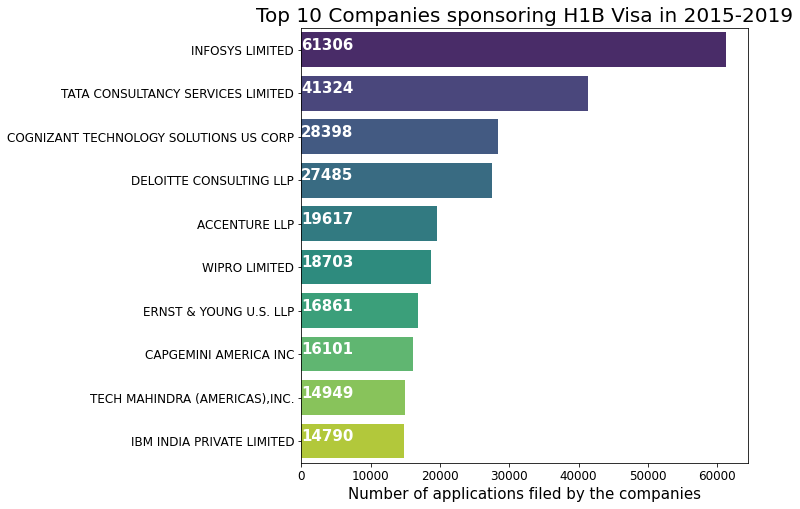

In [15]:
#Plot for top 10 companies that have the most applications for H1B visa
plt=vz.top_employer(plt,sns,cleaned)
plt.show()

In [0]:
cleaned= cw.clean_states(cleaned)

#### Data Scope
The data available contains applications submitted by Employers from 2015 till 2019. \
Geographical Scope: The WORKSITE_STATE gives information about the state where the primary worksite location. The data set covers all the states of US. 
The Data set also cover different Industries majority of the applications are for IT industry but not limited to IT, it also covers Medical, Pharmacy, Law, Carpentery etc.

In [17]:
df=cleaned.SOC_TITLE.value_counts()
df.head(5)

SOFTWARE DEVELOPERS, APPLICATIONS        405792
COMPUTER SYSTEMS ANALYSTS                197344
COMPUTER OCCUPATIONS, ALL OTHER          148097
COMPUTER PROGRAMMERS                     131040
SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE     55978
Name: SOC_TITLE, dtype: int64

In [18]:
df=cleaned.WORKSITE_STATE.value_counts()
df.head(5)

CALIFORNIA    278851
TEXAS         165288
NEW YORK      124075
NEW JERSEY    111103
ILLINOIS       82421
Name: WORKSITE_STATE, dtype: int64

####Faithfulness:
We do not have any inconsistensies in the data apart from some spelling errors in texual data which we are fixing by lemmatizing and using spellcheckers.

In [0]:
#The Job_title and Soc_title has inconsistencies such as numeric characters and symbols so it has to be cleaned
cleaned=cw.text_clean(cleaned) 

In [0]:
#Every column has some values that appear less than 15 times , we are eleminating such rows using the function below
cleaned= cw.drop_less_significant(cleaned)
cleaned=cw.cat_to_num(cleaned) #Function to convert categorical values to numerical values 
# Function to get data science domain jobs
data_scnt,data_anlst,data_eng,mach_learn=cw.data_jobs(cleaned)

## Are you a international student? Are you looking for jobs in Data Science domain?
The below visualization shows median salary for four data science related jobs and the number of visa applications that are submitted for each job. This gives us insights about the jobs available for international students/workers about the job market for Data Science domain. We get to know the number of jobs available for each caegory as well as the median wage for each category. 

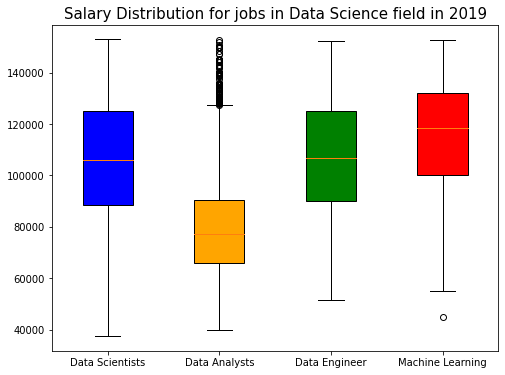

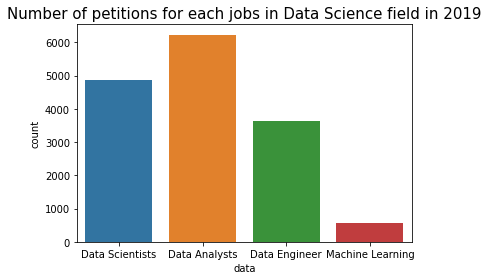

In [22]:
f,ax=plt.subplots(figsize=(8,6))
bplot1=plt.boxplot([data_scnt[data_scnt['WAGES']<200000].WAGES,data_anlst[data_anlst['WAGES']<200000].WAGES,data_eng[data_eng['WAGES']<200000].WAGES,mach_learn[mach_learn['WAGES']<200000].WAGES],patch_artist="True")
ax.set_xticklabels(['Data Scientists','Data Analysts','Data Engineer','Machine Learning'],fontsize=15)
ax.set_title('Salary Distribution for jobs in Data Science field in 2019', fontsize=15)
ax.tick_params(labelsize=10)
colors = ['blue','orange', 'green', 'red'] 
for patch, color in zip(bplot1['boxes'], colors): 
  patch.set_facecolor(color)
plt.show()
datajobs=cw.data_concat(pd,data_scnt,data_anlst,data_eng,mach_learn)
ax2=sns.countplot(x="data", data=datajobs)
ax2.set_title('Number of petitions for each jobs in Data Science field in 2019', fontsize=15)
warnings.simplefilter("ignore")

##Job Distribustion in the US for H1b applicants.
The below visualizations gives us insights into the jobs available in USA for every state. H1B applicants can aim for jobs in states with high job openings.As the majority of applicants are from IT domain and software domain we can see that California has the highest number of jobs.  

In [23]:
cleaned=cw.states_vis(cleaned)
df=cleaned.groupby(['CODE']).size().reset_index(name='counts')
fig=vz.USA_map(go,tls,df)
fig.show()

### Comparison of Education levels for some common courses
![picture](https://drive.google.com/uc?id=1J2SP3r-B17JZSRwkCE34O87iBBqx5CMc)

**Features considered for the classifier**

In [0]:
# Cleaning SOC_TITLE(job_positions) column by removing punctuations
X, Y = cw.fun_preprocessing(cleaned)

The baseline classifier is done with a basic model. In this case we are taking the mean of the labels ('certified' and 'denied' for H1B visa approvals). It will give us the base accuracy to which we will compare our classifier's accuracy. Our classifier should have a better accuracy than the baseline classifier accuracy.

In [0]:
# This step assigns a binary class label (0 or 1) to each label for H1B visa approval. 
y = Y.to_numpy().astype(int) # Groundtruth labels for the dataset

In [27]:
baseline_clasifier_accuracy,mean_AUC=blc.Acceptance_baseline(X,y)
print('Baseline accuracy (K-fold): ', baseline_clasifier_accuracy)
print('AUC K-fold: ', mean_AUC)

Baseline accuracy (K-fold):  0.9925938830376568
AUC K-fold:  0.5


The initial accuracy results of the baseline classifier was 0.99. This result is due to the highly imbalanced data with respect to the Case Status, where there are 624682 CERTIFIED applications and 5158 DENIED applications. The proportion of it is 134.02 to 1. Therefore, a performance measure based on the accuracy is not a good one. A better performance measure in imbalanced data is the Area under the ROC Curve (AUC). It meassures the likelihood that given two random points (one from the positive and one from the negative class) the classifier will rank the point from the positive class higher than the one from the negative one.

#### Balancing Data:
Our Dataset has imbalanced data in the ratio of acceptance to rejection was 134:1 . We are using ADASYN to oversameple the minority and ENN to undersample the Majority class. After balancing the ratio is 2:1.

In [0]:
# Oversampling the minority class
ada = ADASYN(sampling_strategy=0.5, random_state=0)
X_ada, y_ada = ada.fit_resample(X, Y)

In [0]:
# Undersampling the majority class
enn = EditedNearestNeighbours()
X, Y = enn.fit_resample(X_ada, y_ada)

In [0]:
count_y_ada_enn=Counter(Y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)# Testing with regular split
prediction_bl = blc.run_clasifier(X_train, y_train, X_test, np)
split_accuracy = blc.compute_accuracy(y_test, prediction_bl)
split_AUC = blc.compute_AUC(y_test, prediction_bl)
print('Baseline accuracy (split): ', split_accuracy)  
print('AUC split (80-20): ', split_AUC)

Baseline accuracy (split):  0.6409056066579063
AUC split (80-20):  0.5


In [0]:
# Confusion matrix
tn, fp, fn, tp = metrics.confusion_matrix(y_test, prediction_bl).ravel()
print("tn, fp, fn, tp", (tn, fp, fn, tp))

In [33]:
# classification report
report = metrics.classification_report(y_test, prediction_bl)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    157404
         1.0       0.64      1.00      0.78    280932

    accuracy                           0.64    438336
   macro avg       0.32      0.50      0.39    438336
weighted avg       0.41      0.64      0.50    438336



In [0]:
# Plot precision recall curve
plt=vz.plot_precision_recall(plt,y_test, prediction_bl,precision_recall_curve)

### **ML Task 1- Predicting H1B visa application Status using Random Forest**
We are using Random forset classifier to predict if a visa aplication is accepted or rejected. 


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)
model_clf=RandomForestClassifier(n_jobs=2,random_state=0)
model_clf.fit(X_train,y_train)#train the model
prediction_test = model_clf.predict(X_test)#test the model (predict with our test data)
prediction_test

array([0., 1., 1., ..., 0., 1., 0.])

In [40]:
#compare with original value, Y_test
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.973321835304424


In [41]:
# Confusion matrix
metrics.confusion_matrix(y_test, prediction_test)

array([[149099,   8638],
       [  3056, 277543]])

In [42]:
# classification report
report = metrics.classification_report(y_test, prediction_test)
report

'              precision    recall  f1-score   support\n\n         0.0       0.98      0.95      0.96    157737\n         1.0       0.97      0.99      0.98    280599\n\n    accuracy                           0.97    438336\n   macro avg       0.97      0.97      0.97    438336\nweighted avg       0.97      0.97      0.97    438336\n'

In [0]:
y_probs_rand_forest = model_clf.predict_proba(X_test)
vz.plot_precision_recall(plt, y_test, y_probs_rand_forest,precision_recall_curve)

##### **President Trump's "Buy American and Hire American" Executive order's impact on H1B visa**
The "Buy American and Hire American" order was passed on April 18, 2017, to Order to protect American workers and strengthen the American economy. 
The after-effects of which caused a gradual decrease in the request and acceptance of H1B visas have been creating more job opportunities for immigrants which in turn contributes to the American workforce.
It was also observed that just before this order was passed there was a surge in the applications submitted. 
As the graph demonstrates, this type of order, after it has been approved, take some months (around 6 months in this case)  to show the after-effects. It's in 2018 when we see the number of applications and their acceptance is falling so far, as shown in the below visualization.

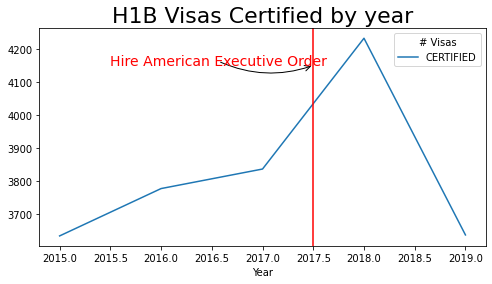

In [58]:
plt=vz.plot_buy_american_order(plt, original, pd)
plt.show()

From the above visualization made on a random sample of about 20000 records from 2015 to 2019, we can infer that the visa acceptance is gradually seen as a downfall, which is one the after-effects of the executive order passed earlier 2017.


### **ML Task 2-WAGE RANGE RANGE PREDICTION:**
Using the data from our dataset we divide the wages into 4 categories which is LOW, AVERAGE, HIGH, VERY_HIGH.
And this predictor will predict the expected salary/wage range for any H1B visa holder or an H1B aspirant based on various factors like location , occupation ,employer etc.


**BASELINE CLASSIFIER FOR WAGE RANGE PREDICTOR:**

In [0]:
#assigning X, y for baseline classifier wage classifier.
cleaned,df_temp = cw.map_wage(cleaned)
X = cleaned['WC_NUM'].to_numpy()
y = df_temp["WC_NUM"].to_numpy().astype(int)

In [60]:
baseline_clasifier_accuracy=blc.baseline_wage(X,y)
print('Baseline accuracy (K-fold): ', baseline_clasifier_accuracy)
split_accuracy=blc.baseline_wage_kfold(X,y)
print('Baseline accuracy (split): ', split_accuracy)

Baseline accuracy (K-fold):  0.7351642569256824
Baseline accuracy (split):  0.7355527960104863


**Features considered for the wage classifier**

In [0]:
Dataset_wage,df_wage=cw.get_df_wage(cleaned)
X,Y = cw.get_XY_wage(Dataset_wage,df_wage)
del Dataset_wage

In [0]:
#Split the date into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)
dec_clf = DecisionTreeClassifier(max_depth=15,criterion='gini')
dec_clf.fit(X_train,y_train)#train the model
prediction_test = dec_clf.predict(X_test)#test the model (predict with our test data)

In [18]:
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))#compare with original value, Y_test

Accuracy =  0.8007084152979086


In [19]:
metrics.confusion_matrix(y_test, prediction_test)

array([[    50,   5230,      7,      0],
       [    22, 128522,    866,      0],
       [     4,  23648,   4123,      1],
       [     2,   2359,    888,      0]])

In [20]:
report = metrics.classification_report(y_test, prediction_test)
print(report)

              precision    recall  f1-score   support

         0.0       0.64      0.01      0.02      5287
         1.0       0.80      0.99      0.89    129410
         2.0       0.70      0.15      0.24     27776
         3.0       0.00      0.00      0.00      3249

    accuracy                           0.80    165722
   macro avg       0.54      0.29      0.29    165722
weighted avg       0.77      0.80      0.74    165722

